# Geospatial Big Data Analytics

## 2nd Project

### Pavlos Kalfantis - MSc Data Science and Machine Learning

This notebook contains the code used to answer the geospatial questions of the second project of the graduate course Geospatial Big Data Analytics at the National Technical University of Athens. This notebook is accompanied by a report that explains in detail the steps taken. 

### Step 0

For this step we install the requied python libraries on the Google Colab environment and we download the dataset that is used (Sentinel-2 data for Kastoria, Greece).

In [ ]:
!pip install rasterio
!pip install owslib
!pip install requests
!pip install contextily
!pip install pandas fiona shapely pyproj rtree --upgrade
!pip install geopandas --upgrade
!pip install folium --upgrade
!pip install matplotlib mapclassify

In [ ]:
!wget https://pithos.okeanos.grnet.gr/public/fBSNLJeNxerluMj2MVDqF

### Step 1


#### 1.1 Raster Data
We unzip the downloaded Sentinel-2 Kastoria files and open with rasterio to explore the contents. There are three files on the directory:

1. Kastoria.pdf explains the contents of the Kastoria.tif file
2. Kastoria.tif has a (2017 x 2281 x 240) image showing a (2017 x 2281) pixel image of kastoria, with 10 bands for 24 days in 2016
3. Kast_RefData_26Classes.tif has 26 different classes on the image collection

#### 1.2 Vector Data
For vector data, we create a polygon within the region of Kastoria using the website [https://geojson.io/](https://geojson.io/), which is then imported in Python with the geopandas library

#### 1.3 Time series Data
Using the website [https://power.larc.nasa.gov/data-access-viewer/](https://power.larc.nasa.gov/data-access-viewer), we collect meteorological data for a specific point within the region of interest for year 2021. There are several parameters that can be selected on this website, as well as a date range and a output file format. We select temperature, relative humidity and surface pressure and a csv output. The data is imported in Python using the geopandas library

#### 1.4 WFS data from Corine Land Cover 2018
Web Feature Service (WFS) Interface Standard provides an interface allowing requests for geographical features across the web using platform-independent calls. We are asked to obtain Corine Land Cover 2018 data through this service and read them in Python. This can be done with the owslib library. However Corine Land Cover 2018 could not be located through the WFS service and the WMS service is used instead


In [3]:
import zipfile
with zipfile.ZipFile('/content/fBSNLJeNxerluMj2MVDqF', 'r') as zip_ref:
    zip_ref.extractall('/content/kastoria_data')

In [2]:
import rasterio
from rasterio.plot import show
import numpy as np
import os
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
from requests import Request, get


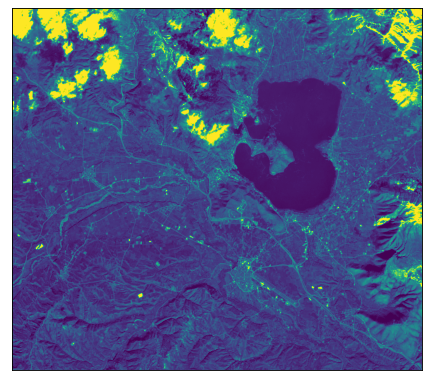

In [5]:
#Read the file and show the first band 

path = os.path.join('/content/kastoria_data/Kastoria.tif')
src = rasterio.open(path)
plt.figure(figsize=(8, 6), dpi=80)
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
show((src, 1))

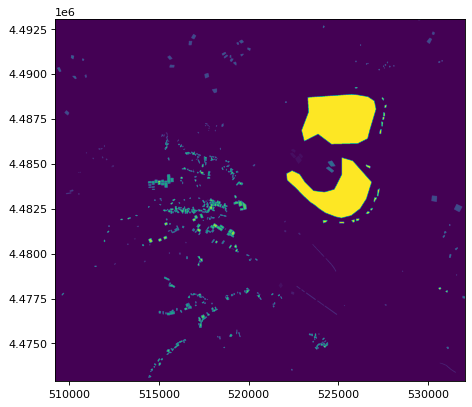

In [6]:
#Show the classes

path = os.path.join('/content/kastoria_data/Kast_RefData_26Classes.tif')
plt.figure(figsize=(8, 6), dpi=80)
classes = rasterio.open(path)
show(classes)

In [4]:
# Read the vector geoJSON file we created on geojson.io

vec = gpd.read_file('/content/kastoria_data/map.geojson')

In [5]:
# Read the csv file we created on pwoer.larc.nasa.gov with pandas

ts_data = pd.read_csv('/content/kastoria_data/POWER_Point_Daily_20160101_20201231.csv', skiprows=11)
ts_data

YEAR  MO  DY   T2M  QV2M     PS
0     2016   1   1 -3.17  2.38  91.18
1     2016   1   2 -0.95  3.23  90.95
2     2016   1   3  0.15  4.21  89.94
3     2016   1   4  1.32  4.76  89.35
4     2016   1   5  3.73  5.68  89.36
...    ...  ..  ..   ...   ...    ...
1822  2020  12  27  4.94  5.92  89.94
1823  2020  12  28  4.23  5.19  89.89
1824  2020  12  29  6.04  5.74  90.15
1825  2020  12  30  6.05  5.86  90.26
1826  2020  12  31  4.94  5.25  90.08

[1827 rows x 6 columns]

In [3]:
# Connect WMS service for Corine Land Cover 2018
from owslib.wms import WebMapService

wms_url = 'https://image.discomap.eea.europa.eu/arcgis/services/Corine/CLC2018_WM/MapServer/WMSServer?request=GetCapabilities&service=WMS'
wms = WebMapService(wms_url)


layers = {}
for i, key in enumerate(wms.contents.keys()):
  k = wms.contents[key].title
  layers[k] = list(wms.contents)[i]

print([op.name for op in wms.operations])
layers

['GetCapabilities', 'GetMap', 'GetFeatureInfo', 'GetStyles']


{'CLC2018_CLC2018_V2018_20u1_FR_GLP_WM': '7',
 'CLC2018_CLC2018_V2018_20u1_FR_Guf_WM': '8',
 'CLC2018_CLC2018_V2018_20u1_FR_MTQ_WM': '9',
 'CLC2018_CLC2018_V2018_20u1_FR_MYT_WM': '10',
 'CLC2018_CLC2018_V2018_20u1_FR_REU_WM': '11',
 'Corine Land Cover 2018 raster': '12',
 'Corine Land Cover 2018 vector': '13',
 'U2018_CLC2018_V2020_20u1_FR_GLP_R_WM': '1',
 'U2018_CLC2018_V2020_20u1_FR_GUF_R_WM': '2',
 'U2018_CLC2018_V2020_20u1_FR_MTQ_R_WM': '3',
 'U2018_CLC2018_V2020_20u1_FR_MYT_R_WM': '4',
 'U2018_CLC2018_V2020_20u1_FR_REU_R_WM': '5'}

### Step 2

Step 2 was about visualizing raster data that was imported on the previous step.

#### 2.1 Visualize RGB channels for  Sentinel-2 data

For the sentinel-2 data that was downloaded for the area of Kastoria, we visualize for a specific date (first day of the dataset) the red, green and blue bands on the corresponding color map

#### 2.2 Mask raster image based on polygon (vector) of previous step

We mask the polygon previously created on the raster images. First we need to have both raster and vector files on the same Coordinate reference system (crs)

#### 2.3 Compute daily NDVI value 

We visualize the ndv index for each available date and then compute the mean of the polygon area

#### 2.4 Create time series graph for NDVI

The mean NDV index calculated previously for each day is plotted against the time

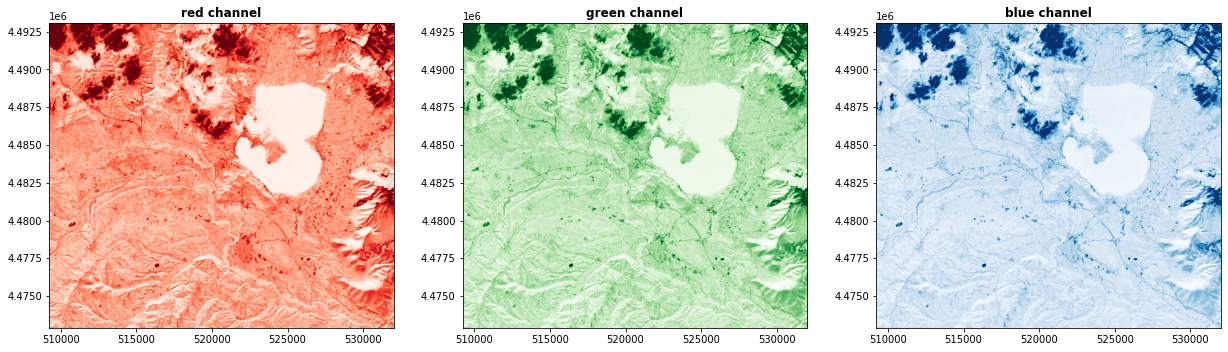

In [11]:
#  RGB visualization

fig, (axr, axg, axb) = plt.subplots(1,3, figsize=(21,7))
show((src, 3), ax=axr, cmap='Reds', title='red channel')

show((src, 2), ax=axg, cmap='Greens', title='green channel')

show((src, 1), ax=axb, cmap='Blues', title='blue channel')

plt.show()

In [13]:
print(vec.crs,src.crs)

# Different Coordinate Reference System, need to transform raster data

epsg:4326 EPSG:32634


In [14]:
#Transform raster data
from rasterio.warp import calculate_default_transform, reproject, Resampling

crs = vec.crs
def reproject_raster(in_path, out_path):

    # reproject raster to project crs
    with rasterio.open(in_path) as src:
        src_crs = src.crs
        transform, width, height = calculate_default_transform(src_crs, crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()

        kwargs.update({
            'crs': crs,
            'transform': transform,
            'width': width,
            'height': height})

        with rasterio.open(out_path, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=crs,
                    resampling=Resampling.nearest)
    return(out_path)

reproject_raster('/content/kastoria_data/Kastoria.tif','/content/kastoria_data/Kastoria_new.tif')

'/content/kastoria_data/Kastoria_new.tif'

In [15]:
# Mask raster data with vector data

import rasterio.mask
import fiona

with fiona.open("/content/kastoria_data/map.geojson", "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

with rasterio.open("/content/kastoria_data/Kastoria_new.tif") as src:
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
    out_meta = src.meta


out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
with rasterio.open('/content/kastoria_data/Kastoria_new_masked.tif', "w", **out_meta) as dest:
    dest.write(out_image)

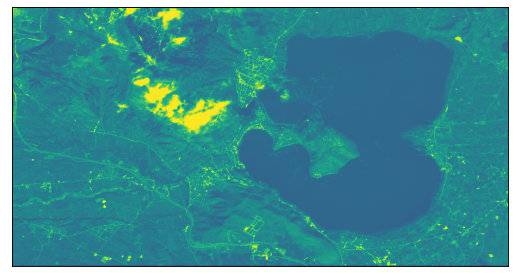

In [16]:
#Plot sample masked image

plt.figure(figsize=(8, 6), dpi=80)
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.imshow(out_image[0])

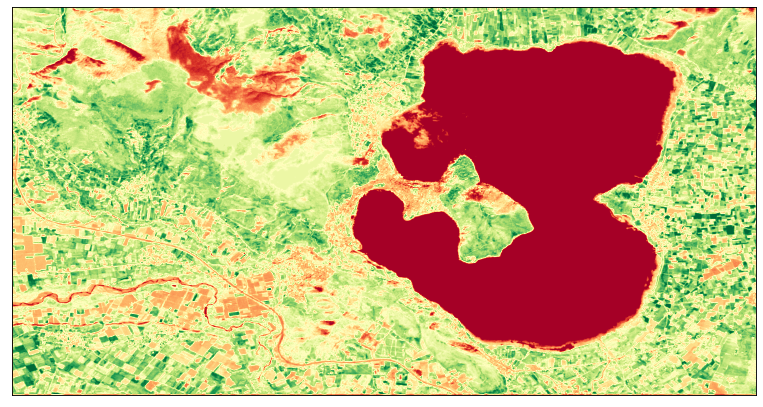

In [ ]:
#Plot sample ndvi index 


plt.figure(figsize=(12, 12), dpi=80)
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.imshow(out_image[6],cmap='RdYlGn')

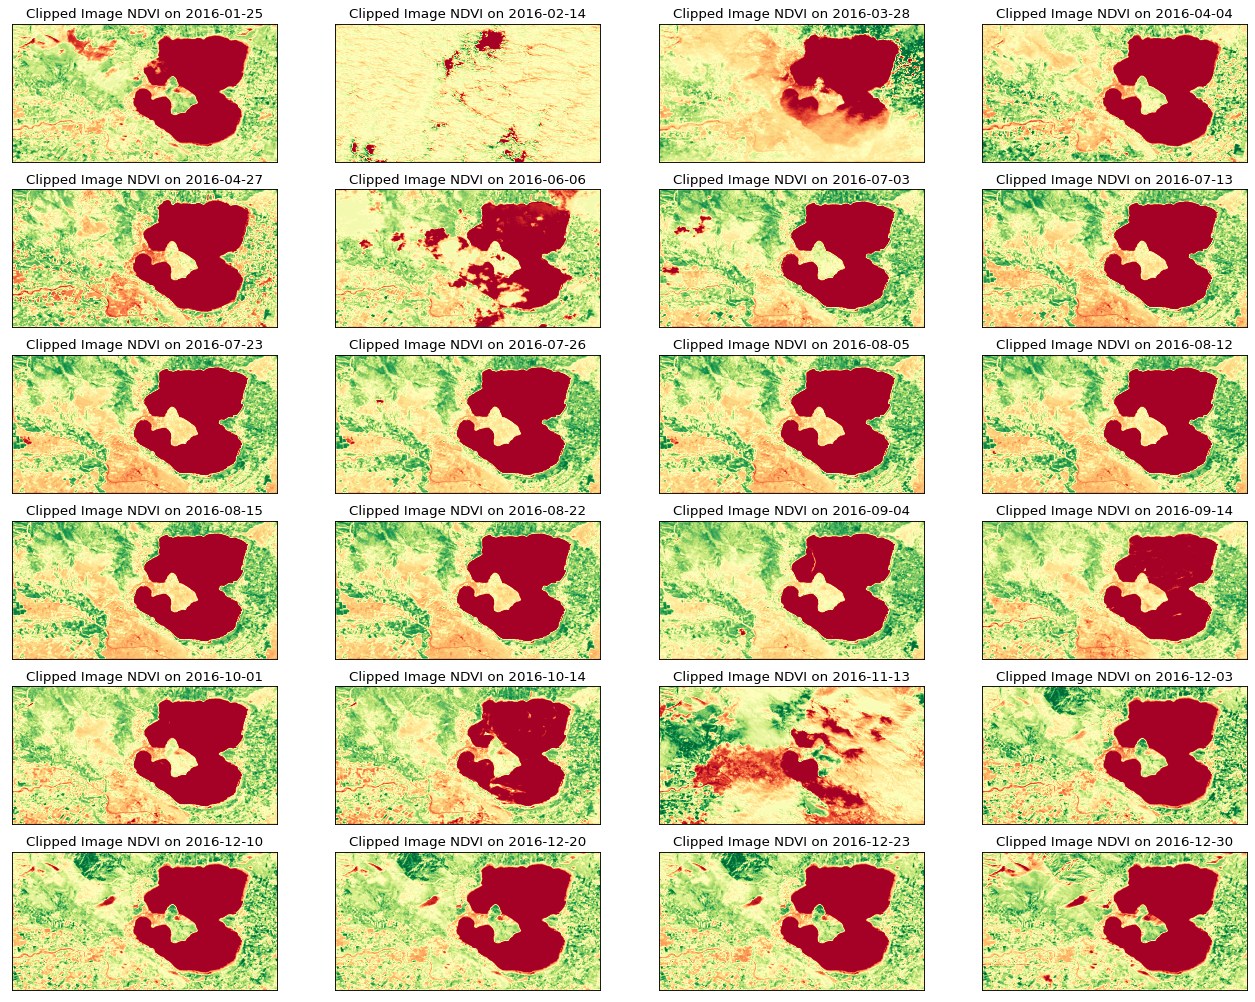

In [ ]:
#Plot all ndvi images 

available_dates = ['2016-01-25','2016-02-14','2016-03-28','2016-04-04','2016-04-27',\
        '2016-06-06','2016-07-03','2016-07-13','2016-07-23','2016-07-26',\
        '2016-08-05','2016-08-12','2016-08-15','2016-08-22','2016-09-04',\
        '2016-09-14','2016-10-01','2016-10-14','2016-11-13','2016-12-03',\
        '2016-12-10','2016-12-20','2016-12-23','2016-12-30']

ndvi_indices = [i for i in range(6,237,10)]

plt.figure(figsize=(20, 16), dpi=80)

for i in range(6):
    for j in range(4):
        index = j+i*4
        ax = plt.subplot2grid((6,4), (i,j))
        ax.set_title('Clipped Image NDVI on '+available_dates[index])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.imshow(out_image[ndvi_indices[index]],cmap='RdYlGn')
plt.show()

In [ ]:
# Calculate mean ndvi of each date for the clipped image and plot
ndvi_means = []
for index in ndvi_indices:
  ndvi_means.append(out_image[index].mean())

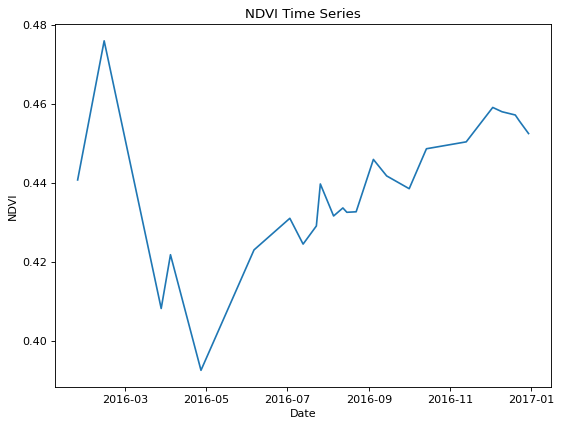

In [ ]:
import pandas as pd

values = {'dates': available_dates,
          'ndvi': ndvi_means
          }

df = pd.DataFrame(values)
df['dates'] = pd.to_datetime(df['dates'], format='%Y-%m-%d')

plt.figure(figsize=(8, 6), dpi=80)
plt.title('NDVI Time Series')
plt.xlabel('Date')
plt.ylabel('NDVI')
plt.plot(df.dates,df.ndvi)

### Step 3

Step 3 was about answering geospatial questions using the Geopandas python library, as well as creating static maps and time series plots

#### 3.1 Vector data from geodata.gov.gr

We use the Web Feature Service to get the data from geodata.gov.gr and inspect the different layers. These will be used to create static maps

#### 3.2 Geopandas

Some basic geospatial aggregations and questions are answered with Geopandas, using the vector data obtained on previous steps

#### 3.3 WFS Corine Land Cover 

We use the WMS of Corine Land Cover 2018 to get data (raster images) from Copernicus' website.

#### 3.4 Static Maps

The Corine Land Cover data is plotted using rasterio

#### 3.5 Time Series Plots

Time series plots for temperature, pressure and humidity are created for the point that was defined in step 1

In [6]:
#geodata.gov.gr vector data

from owslib.wfs import WebFeatureService
wfs_url = 'http://geodata.gov.gr/geoserver/ows'
wfs = WebFeatureService(wfs_url)
layers = {}
for i, key in enumerate(wfs.contents.keys()):
  k = wfs.contents[key].title
  layers[k] = list(wfs.contents)[i]


In [7]:
geodata_gr_layers = list(layers.keys())
geodata_gr_layers

['AERODROMIA',
 'Arxaiologikos_xoros',
 'FRAGMATA_ELLADAS',
 'USA Population',
 'aigialos_alexandroupolis',
 'aigialos_deh_chaliwth',
 'aigialos_fira',
 'aigialos_fourkaria',
 'aigialos_freatida',
 'aigialos_karapolith',
 'aigialos_karkani',
 'aigialos_mandraki',
 'aigialos_mikrolimano',
 'aigialos_samothrakhs',
 'aigialos_zastano',
 'aisthitika_dash',
 'aktogrammh',
 'aktogrammi',
 'arithmhsh_dromwn',
 'at_da',
 'brefonip_da',
 'crete_iso_200',
 'daktylios_da',
 'dasarxeia',
 'delta_falhrou',
 'dhmosia_kthria',
 'dhmosia_wifi',
 'dianomh_fyllwn_xartoy_OKXE_1_pros_5000_EGSA87',
 'diethneis_synthikes',
 'dimotika_at',
 'ektrofeia_thiramatwn',
 'elegxomenes_kynhgetikes_perioxes',
 'elegxomenes_kynigetikes_perioxes',
 'enories_athinwn',
 'ethikoi_drymoi',
 'ethnika_parka',
 'ethniko_parko_sxinia',
 'ethnikos_drymos_oitis',
 'fysiko_aerio_kommothnh_alexandroupolh',
 'galazies_shmaies_2008',
 'galazies_shmaies_2009',
 'galazies_shmaies_2010',
 'iso_50_hrakleio',
 'istoriko_kentro_da_line',


In [30]:
len(geodata_gr_layers)

122

In [8]:
#Function to read data from geodata.gov.gr to a GeoPandas dataframe

def geodata_gr_to_gpd(key):
  # Specify the parameters for fetching the data
  params = dict(service='WFS', version="1.0.0", request='GetFeature',
      typeName=layers[key], outputFormat='json')

  # Parse the URL with parameters
  q = Request('GET', wfs_url, params=params).prepare().url
  gpd_df = gpd.read_file(q)
  return gpd_df

In [9]:
aerodromia = geodata_gr_to_gpd('AERODROMIA')
ydrografiko_diktyo = geodata_gr_to_gpd('ydrografiko_diktyo')
periphereies = geodata_gr_to_gpd('periphereies')
sidirodromiko = geodata_gr_to_gpd('sidhrodromiko_diktyo')
limania = geodata_gr_to_gpd('limania')
potamoi = geodata_gr_to_gpd('potamoi')

In [25]:
aerodromia.crs ==  limania.crs

True

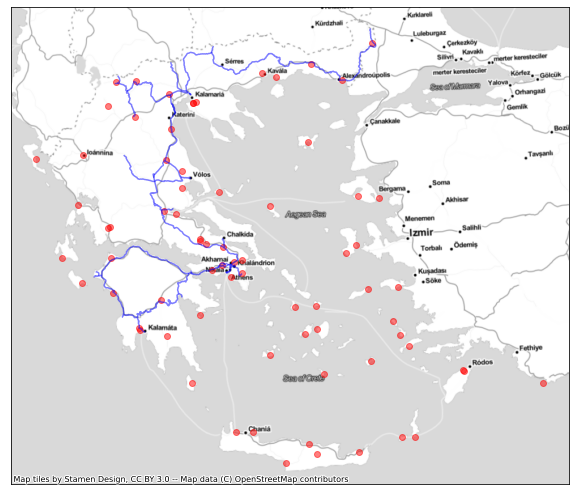

In [31]:
import contextily as cx
import matplotlib.pyplot as plt
import xyzservices.providers as xyz


fig , ax = plt.subplots(figsize=(10, 10))

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
aerodromia.plot(ax=ax, alpha=0.5, color='red')
sidirodromiko.plot(ax=ax, alpha=0.5, color='blue' )
cx.add_basemap(ax, crs=sidirodromiko.crs, source=cx.providers.Stamen.TonerLite)

In [44]:
#Join peripheries and aerodromia dataframes

airports_regions = gpd.sjoin(aerodromia, periphereies)
airports_regions["PER"].value_counts()

Π. ΝΟΤΙΟΥ ΑΙΓΑΙΟΥ                    15
Π. ΑΤΤΙΚΗΣ                            7
Π. ΣΤΕΡΕΑΣ ΕΛΛΑΔΑΣ                    7
Π. ΒΟΡΕΙΟΥ ΑΙΓΑΙΟΥ                    7
Π. ΚΡΗΤΗΣ                             6
Π. ΚΕΝΤΡΙΚΗΣ ΜΑΚΕΔΟΝΙΑΣ               6
Π. ΠΕΛΟΠΟΝΝΗΣΟΥ                       5
Π. ΔΥΤΙΚΗΣ ΕΛΛΑΔΑΣ                    5
Π. ΑΝΑΤΟΛΙΚΗΣ ΜΑΚΕΔΟΝΙΑΣ - ΘΡΑΚΗΣ     5
Π. ΘΕΣΣΑΛΙΑΣ                          4
Π. ΙΟΝΙΩΝ ΝΗΣΩΝ                       3
Π. ΔΥΤΙΚΗΣ ΜΑΚΕΔΟΝΙΑΣ                 3
Π. ΗΠΕΙΡΟΥ                            1
Name: PER, dtype: int64

In [34]:
airports_regions

id_left                                onoma  \
0         1      Δασκαλογιάννης CHQ Χανιά, Σούδα   
1         2                               Μάλεμε   
2         3                       Τυμπάκι LG54\n   
3         4  Νίκος Καζαντζάκης LGIR HER Ηράκλειο   
4         5                       Καστέλι LGTL\n   
..      ...                                  ...   
59       60                      Πολιχνίτος LG0D   
60       61                        Χίου LGHI JKH   
61       62                         Ολύμποι LG56   
62       63            Αρίσταρχος LGSM SMI Σάμος   
63       64                      Ικαρία LGIK JIK   

                          geometry  index_right  \
0   POINT (512886.533 3932001.696)           11   
1   POINT (484540.131 3931694.148)           11   
2   POINT (568297.267 3880601.588)           11   
3   POINT (607090.104 3911052.691)           11   
4   POINT (620681.353 3894883.025)           11   
..                             ...          ...   
59  POINT (689721.545 4328713.819)            5   
60  POINT (686909.003 4245689.370)            5   
61  POINT (669490.291 4233504.672)            5   
62  POINT (756766.879 4175167.374)            5   
63  POINT (706680.633 4173138.147)            5   

                                   id_right                 PER  
0   d7f50467-e5ef-49ac-a7ce-15df3e2ed738.11           Π. ΚΡΗΤΗΣ  
1   d7f50467-e5ef-49ac-a7ce-15df3e2ed738.11           Π. ΚΡΗΤΗΣ  
2   d7f50467-e5ef-49ac-a7ce-15df3e2ed738.11           Π. ΚΡΗΤΗΣ  
3   d7f50467-e5ef-49ac-a7ce-15df3e2ed738.11           Π. ΚΡΗΤΗΣ  
4   d7f50467-e5ef-49ac-a7ce-15df3e2ed738.11           Π. ΚΡΗΤΗΣ  
..                                      ...                 ...  
59   d7f50467-e5ef-49ac-a7ce-15df3e2ed738.5  Π. ΒΟΡΕΙΟΥ ΑΙΓΑΙΟΥ  
60   d7f50467-e5ef-49ac-a7ce-15df3e2ed738.5  Π. ΒΟΡΕΙΟΥ ΑΙΓΑΙΟΥ  
61   d7f50467-e5ef-49ac-a7ce-15df3e2ed738.5  Π. ΒΟΡΕΙΟΥ ΑΙΓΑΙΟΥ  
62   d7f50467-e5ef-49ac-a7ce-15df3e2ed738.5  Π. ΒΟΡΕΙΟΥ ΑΙΓΑΙΟΥ  
63   d7f50467-e5ef-49ac-a7ce-15df3e2ed738.5  Π. ΒΟΡΕΙΟΥ ΑΙΓΑΙΟΥ  

[74 rows x 6 columns]

(-56.505142, 24.283655, 72.906158, 72.66441, 'EPSG:4326')
['EPSG:3857', 'EPSG:4326', 'EPSG:102100', 'EPSG:3035']
{'default': {'title': 'Corine Land Cover 2018 raster', 'legend': 'https://image.discomap.eea.europa.eu/arcgis/services/Corine/CLC2018_WM/MapServer/WMSServer?request=GetLegendGraphic%26version=1.1.1%26format=image/png%26layer=12'}}


/usr/local/lib/python3.7/dist-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


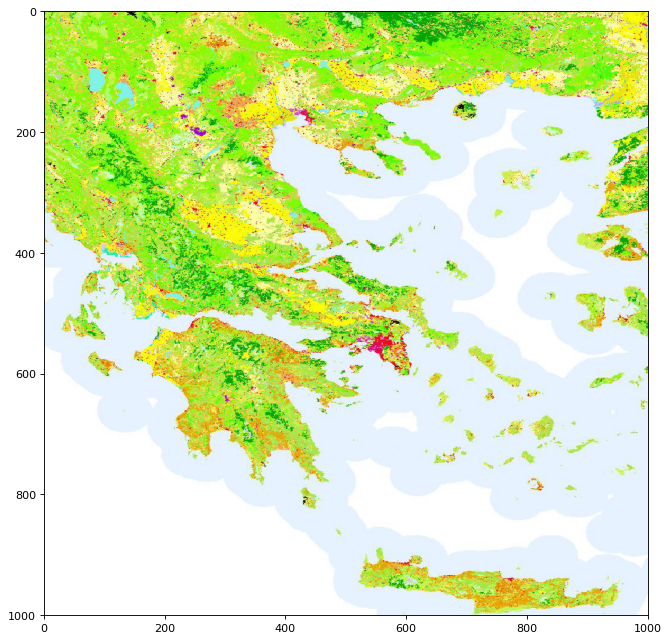

In [ ]:
# Read wms layer 12 (raster) with GetMap

print(wms.contents['12'].boundingBox)
print(wms.contents['12'].crsOptions)
print(wms.contents['12'].styles)

request = wms.getmap(   layers=['12'],
                  styles=['default'],
                  srs='EPSG:4326', 
                  bbox=(20.1500159034, 34.9199876979, 26.6041955909, 41.8269046087), #Greece
                  size=(1000, 1000),
                  format='image/jpeg' #jpeg/tiff/geotiff
                           )
out = open('greece.jpeg', 'wb')
out.write(request.read())
out.close()

path = os.path.join('/content/greece.jpeg')
plt.figure(figsize=(10, 10), dpi=80)
greece = rasterio.open(path)
show(greece)

(-56.505142, 24.283655, 72.906158, 72.66441, 'EPSG:4326')
['EPSG:3857', 'EPSG:4326', 'EPSG:102100', 'EPSG:3035']
{'default': {'title': 'Corine Land Cover 2018 raster', 'legend': 'https://image.discomap.eea.europa.eu/arcgis/services/Corine/CLC2018_WM/MapServer/WMSServer?request=GetLegendGraphic%26version=1.1.1%26format=image/png%26layer=12'}}


/usr/local/lib/python3.7/dist-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


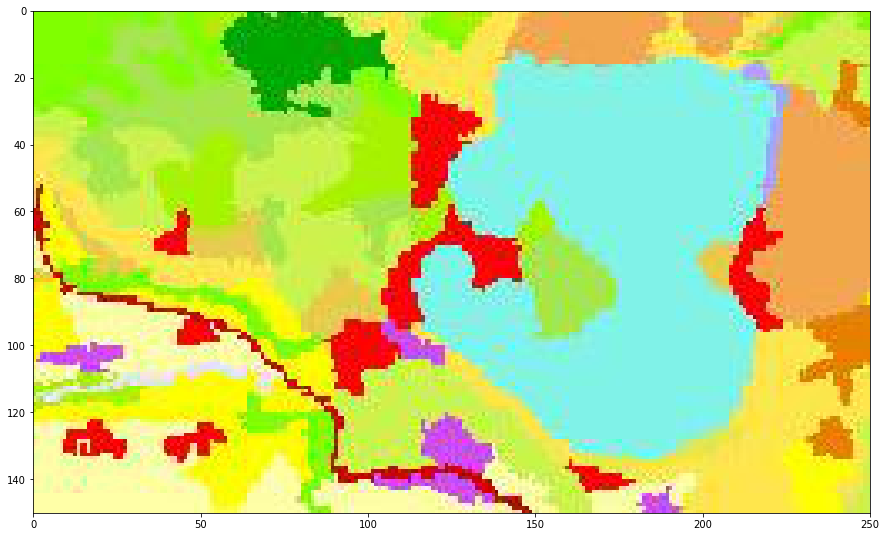

In [ ]:
# Read wms layer 12 (raster) with GetMap

print(wms.contents['12'].boundingBox)
print(wms.contents['12'].crsOptions)
print(wms.contents['12'].styles)

request = wms.getmap(   layers=['12'],
                  styles=['default'],
                  srs='EPSG:4326', 
                  bbox=(21.17992401123047, 40.475158405878716, 21.34334564208984, 40.56024300905358), #Kastoria
                  size=(250, 150),
                  format='image/jpeg' #jpeg/tiff/geotiff
                           )
out = open('kastoria.jpeg', 'wb')
out.write(request.read())
out.close()

path = os.path.join('/content/kastoria.jpeg')
plt.figure(figsize=(15, 10))
kastoria = rasterio.open(path)
show(kastoria)

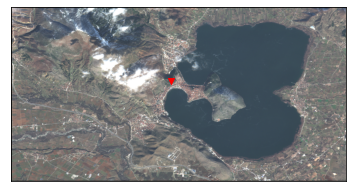

<Figure size 864x432 with 0 Axes>

In [40]:
#Show clipped image and point of meteorological data

path = os.path.join('/content/kastoria_data/Kastoria_new_masked.tif')
# Open the file:
Kastoria_new_masked = rasterio.open(path)

df = pd.DataFrame(
    {'Latitude': [40.5242],
     'Longitude': [21.258]})

gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))


fig, ax = plt.subplots()
plt.figure(figsize=(12, 6))

# transform rasterio plot to real world coords
extent=[Kastoria_new_masked.bounds[0], Kastoria_new_masked.bounds[2], Kastoria_new_masked.bounds[1], Kastoria_new_masked.bounds[3]]
ax = rasterio.plot.show((Kastoria_new_masked, (3,2,1)), extent=extent, ax=ax)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
gdf.plot(ax=ax, marker ='v', color = 'red')

In [ ]:
# Time Series Plots
ts_data.rename(columns = {'YEAR': 'year', 'MO': 'month', 'DY':'day'}, inplace = True)

ts_data['date']=pd.to_datetime(ts_data[['year', 'month', 'day']])

ts_data

year  month  day   T2M  QV2M     PS       date
0     2016      1    1 -3.17  2.38  91.18 2016-01-01
1     2016      1    2 -0.95  3.23  90.95 2016-01-02
2     2016      1    3  0.15  4.21  89.94 2016-01-03
3     2016      1    4  1.32  4.76  89.35 2016-01-04
4     2016      1    5  3.73  5.68  89.36 2016-01-05
...    ...    ...  ...   ...   ...    ...        ...
1822  2020     12   27  4.94  5.92  89.94 2020-12-27
1823  2020     12   28  4.23  5.19  89.89 2020-12-28
1824  2020     12   29  6.04  5.74  90.15 2020-12-29
1825  2020     12   30  6.05  5.86  90.26 2020-12-30
1826  2020     12   31  4.94  5.25  90.08 2020-12-31

[1827 rows x 7 columns]

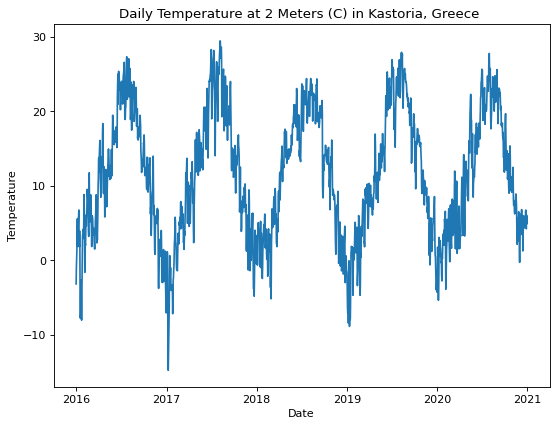

In [ ]:
plt.figure(figsize=(8, 6), dpi=80)
plt.title('Daily Temperature at 2 Meters (C) in Kastoria, Greece ')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.plot(ts_data.date,ts_data.T2M)

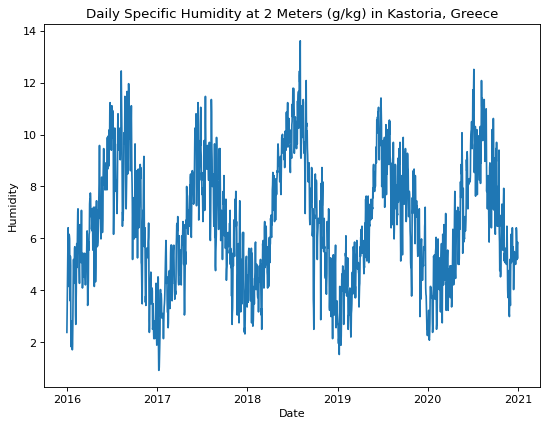

In [ ]:
plt.figure(figsize=(8, 6), dpi=80)
plt.title('Daily Specific Humidity at 2 Meters (g/kg) in Kastoria, Greece')
plt.xlabel('Date')
plt.ylabel('Humidity')
plt.plot(ts_data.date,ts_data.QV2M)

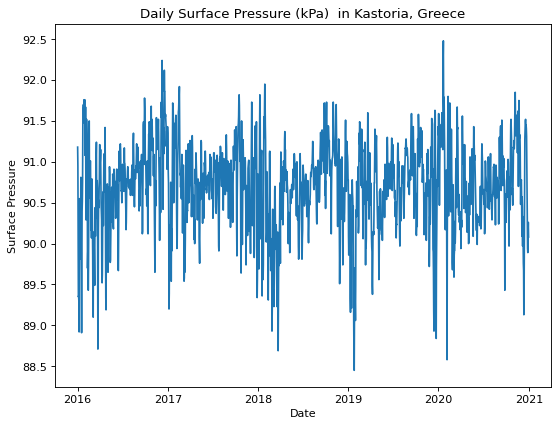

In [ ]:
plt.figure(figsize=(8, 6), dpi=80)
plt.title('Daily Surface Pressure (kPa)  in Kastoria, Greece')
plt.xlabel('Date')
plt.ylabel('Surface Pressure')
plt.plot(ts_data.date,ts_data.PS)

### Step 4 - Dynamic Maps

For this question, dynamic maps were created with the leafmap python library, for data collected on previous steps as well as data collected with the Web Map Service (WMS)

In [ ]:
!pip install leafmap

In [12]:
#Map of airports in Greece

import leafmap

m = leafmap.Map(center=[20, 0], zoom=1)
m.add_gdf(aerodromia, "Greek Airports")
m

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

In [19]:
#United States Land Cover

m = leafmap.Map()
url = "https://www.mrlc.gov/geoserver/mrlc_display/NLCD_2019_Land_Cover_L48/wms?"
m.add_wms_layer(
    url,
    layers="NLCD_2019_Land_Cover_L48",
    name="NLCD 2019 CONUS Land Cover",
    format="image/png",
    transparent=True,
)
m.add_legend(builtin_legend='NLCD')
m

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…